## Application
We demonstrate an application of our method in recovering an original image from a noisy image. We use MNIST images of handwritten digits to illustrate this idea.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import emachine as EM
import itertools

In [2]:
np.random.seed(0)

We first select a real image from a testing set of MNIST data.

In [3]:
s0 = np.loadtxt('../MNIST_data/mnist_test.csv',delimiter=',')

seq = s0[:,1:] 
label = s0[:,0]

# select only 1 digit
digit = 8
seq1 = seq[label == digit]
print(digit,seq1.shape)

# convert to binary
seq1 = np.sign(seq1-1.5)

# select only one test sample to consider
t = 2
seq1 = seq1[t]

8 (974, 784)


Suppose the image has `n_hidden` missing pixels. We set their values to be zero.

In [4]:
# select hidden pixels
n_hidden = 90
hidden = np.random.choice(np.arange(28*28),n_hidden,replace=False)

# set value at hidden position to be zero
seq_hidden = seq1.copy()
seq_hidden[hidden] = 0.

We plot the original image and the noisy image.

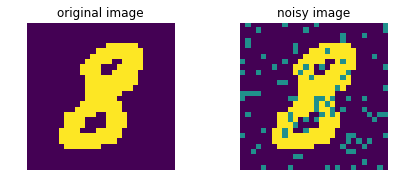

In [5]:
nx,ny = 2,1
fig, ax = plt.subplots(ny,nx,figsize=(nx*3,ny*2.8))
ax[0].imshow(seq1.reshape(28,28),interpolation='nearest')
ax[1].imshow(seq_hidden.reshape(28,28),interpolation='nearest')

ax[0].set_title('original image')
ax[1].set_title('noisy image')

for i in range(nx):
    ax[i].set_axis_off()
    
plt.tight_layout(h_pad=0.7, w_pad=1.5)
#plt.savefig('fig_hidden.pdf', format='pdf', dpi=100)

We aim to reconstruct the missing pixels, and recover the original image. We use images of the same digit from the MNIST training set. Because of the limitation of sample size (n_seq = 5851), compared with number of variables (n_var = 28 x 28 = 784 pixels), we first identify "conserved" pixels that have common values for more than 80% of the training samples.

We then find conserved and active pixels from training data.

In [6]:
# load train data
s0_train = np.loadtxt('../MNIST_data/mnist_train.csv',delimiter=',')

seq_train = s0_train[:,1:] 
label_train = s0_train[:,0]

# select only 1 digit
seq1_train = seq_train[label_train == digit] #digit = 8

# convert to binary
seq1_train = np.sign(seq1_train-1.5)
print(seq1_train.shape)

(5851, 784)


In [7]:
# find conserved pixels from traing data
n,m = seq1_train.shape
frequency = [(seq1_train[:,i] == -1).sum()/float(n) for i in range(m)]

cols_pos = [i for i in range(m) if frequency[i] < 0.2] # 80% positive
cols_neg = [i for i in range(m) if frequency[i] > 0.8] # 80% negative
cols_conserved = cols_pos + cols_neg

# active pixels
cols_active = np.delete(np.arange(0,m),cols_conserved)

print(len(cols_pos),len(cols_neg),len(cols_conserved),len(cols_active))

49 513 562 222


In this case, there are 562 conserved pixels in total, including 49 positive pixels and 513 negative pixels. There are 222 active pixels.

To reconstruct the value of conserved hidden pixels (of the test image), we simply set the value of conserved hidden pixels of the test image as the value of corresponding pixels in the training data.

In [8]:
hidden_conserved = np.intersect1d(hidden,cols_conserved)
hidden_active = np.intersect1d(hidden,cols_active)

n_hidden_conserved = len(hidden_conserved)
n_hidden_active = len(hidden_active)
print('n_hidden_active:',len(hidden_active))

## recover hidden
seq_recover = seq_hidden.copy()

hidden_neg = np.intersect1d(hidden_conserved,cols_neg)
hidden_pos = np.intersect1d(hidden_conserved,cols_pos)

seq_recover[hidden_neg] = -1.
seq_recover[hidden_pos] = 1.

n_hidden_active: 26


Now, there are `n_hidden_active` (i.e., 26 in this example) hidden pixels that we need to find the values of. We will apply our $\epsilon$-machine to find the pixel bias and interactions between 222 active pixels.

We find pixel bias and interactions of active pixels (from training data).

In [9]:
seq_train_active = seq1_train[:,cols_active]
print((seq_train_active.shape))

ops = EM.operators(seq_train_active)
print(ops.shape)

eps_list = np.linspace(0.92,0.98,5)
E_eps = np.zeros(len(eps_list))
w_eps = np.zeros((len(eps_list),ops.shape[1]))
for i,eps in enumerate(eps_list):    
    w_eps[i,:],E_eps[i] = EM.fit(ops,eps=eps,max_iter=100)
    print(eps,E_eps[i])
    
ieps = np.argmax(E_eps)
print('optimal eps:',eps_list[ieps])
w = w_eps[ieps]
#np.savetxt('w.dat',w,fmt='%f')    

(5851, 222)
(5851, 24753)
0.92 -711.6255597866084
0.935 -705.7689428451328
0.95 -706.8546800350513
0.965 -719.9330903444665
0.98 -767.5753296194733
optimal eps: 0.935


We then apply these to the test image and select the best active hidden pixel vector. This step requires a large computer memory and we perform this procedure by using a computing server.

In [ ]:
# consider every possibilities of configurations of the active hidden pixels
seq_all = np.asarray(list(itertools.product([1.0, -1.0], repeat=n_hidden_active)))
n_possibles = seq_all.shape[0]
print('number of possible configs:',n_possibles)

active_hidden_indices = np.intersect1d(cols_active,hidden_active,
                                       return_indices=True)[1]

seq_active = seq1[cols_active]
seq_active_possibles = np.tile(seq_active,(n_possibles,1))
seq_active_possibles[:,active_hidden_indices] = seq_all

# calculate energy of each possible configuration
npart = 128   # devide into npart because of PC memory limitation
ns = int(n_possibles/npart)
energy = np.full(n_possibles,100000.)
for i in range(npart):
    i1 = int(i*ns)
    i2 = int((i+1)*ns)
    if i%5 == 0: print('ipart:',i)
    ops = EM.operators(seq_active_possibles[i1:i2])
    energy[i1:i2] = -ops.dot(w)
    
# select the best sequence that maximize probability
seq_recover[hidden_active] = seq_all[np.argmin(energy)]     

We load the computed result from the code above.

In [12]:
seq_recover = np.loadtxt('seq_recover_90.dat')

We plot the image we recovered.

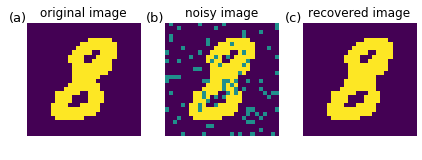

In [14]:
nx,ny = 3,1
nfig = nx*ny
fig, ax = plt.subplots(ny,nx,figsize=(nx*2.0,ny*2.6))
ax[0].imshow(seq1.reshape(28,28),interpolation='nearest')
ax[1].imshow(seq_hidden.reshape(28,28),interpolation='nearest')
ax[2].imshow(seq_recover.reshape(28,28),interpolation='nearest')

ax[0].set_title('original image')
ax[1].set_title('noisy image')
ax[2].set_title('recovered image')

for i in range(nx):
    ax[i].set_axis_off()
    
label = ['(a)','(b)','(c)','(d)','(e)','(g)','(d)','(h)']
xlabel = np.full(nfig,0.0)
ylabel = np.full(nfig,1.1)
k = 0
for i in range(nx):        
    ax[i].text(xlabel[k],ylabel[k],label[k],transform=ax[i].transAxes,
               va='top',ha='right',fontsize=13)
    k += 1
        
plt.tight_layout(h_pad=0.0, w_pad=0.5)
#plt.savefig('fig.pdf', format='pdf', dpi=100)

The recovered image looks like the original image.